# 1/Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import hdbscan

# 2/Read Dataset

## Check suitable chunk size for reading a large dataset

In [2]:
chunk_size = 500000
file_path = "../data/raw/question1_data.csv"

In [2]:


chunks = pd.read_csv(file_path, chunksize=chunk_size)

# List to keep track of memory usages of each chunk
memory_usages = []

for index, chunk in enumerate(chunks):
    # Get memory usage of the chunk (in bytes)
    mem_usage = chunk.memory_usage(deep=True).sum()
    
    # Convert memory usage to megabytes for easier reading
    mem_usage_mb = mem_usage / (1024 ** 2)  # Convert bytes to megabytes
    memory_usages.append(mem_usage_mb)
    
    print(f"Chunk {index + 1} Memory Usage: {mem_usage_mb:.2f} MB")

# If you want to get the average memory usage across all chunks:
avg_mem_usage = sum(memory_usages) / len(memory_usages)
print(f"\nAverage Memory Usage per Chunk: {avg_mem_usage:.2f} MB")


Chunk 1 Memory Usage: 55.16 MB
Chunk 2 Memory Usage: 55.16 MB
Chunk 3 Memory Usage: 55.16 MB
Chunk 4 Memory Usage: 2.86 MB

Average Memory Usage per Chunk: 42.09 MB


## Read the dataset in chunks then concatenate back into a single dataframe

In [3]:
chunks = pd.read_csv(file_path, chunksize=chunk_size)

# Initialize an empty list to store dataframes (optional)
dfs = []

for chunk in chunks:
    # Process each chunk (if needed). For demonstration, we're simply appending them to a list.
    dfs.append(chunk)

# Concatenate chunks back into a single dataframe.
df = pd.concat(dfs, axis=0)

## Check basic information of the dataframe

In [4]:
df.head()

,id,stretch,theta,twist,avg_stretch,avg_twist,distance
0,7odcA:F:4,10.68,45.4,-152.8,10.53,211.3,8.1
1,7odcA:T:5,10.38,51.1,-144.6,10.41,180.0,-70.8
2,7odcA:K:6,10.44,41.8,144.6,8.69,78.3,-132.6
3,7odcA:D:7,6.93,87.9,12.0,6.28,337.9,-68.2
4,7odcA:E:8,5.63,84.3,-56.2,7.10,22.3,157.0


In [5]:
print(f"Data shape (rows, columns): {df.shape}")
print(f"Columns names: \n{df.columns}")

Data shape (rows, columns): (1525931, 7)
Columns names: 
Index(['id', 'stretch', 'theta', 'twist', 'avg_stretch', 'avg_twist',
       'distance'],
      dtype='object')


# 3/Exploratory Data Analysis

## 3.1/ Data Quality

### Check for missing and duplicated values

In [6]:
print(f"Number of missing values: \n{df.isna().sum()}\n")
print(f"Number of duplicated rows: \n{df.duplicated().sum()}")

Number of missing values: 
id             0
stretch        0
theta          0
twist          0
avg_stretch    0
avg_twist      0
distance       0
dtype: int64

Number of duplicated rows: 
0


### Check unique values

In [7]:
print(f"Theta: {len(df['theta'].unique())}")
print(f"Stretch: {len(df['stretch'].unique())}")
print(f"Average Stretch: {len(df['avg_stretch'].unique())}")
print(f"Twist: {len(df['twist'].unique())}")
print(f"Average Twist: {len(df['avg_twist'].unique())}")
print(f"Distance: {len(df['distance'].unique())}")

Theta: 1065
Stretch: 734
Average Stretch: 662
Twist: 3601
Average Twist: 3601
Distance: 3601


## 3.2/ Univariate Analysis

### Statistical Summary

In [8]:
df.describe()

,stretch,theta,twist,avg_stretch,avg_twist,distance
count,1.525931e+06,1.525931e+06,1.525931e+06,1.525931e+06,1.525931e+06,1.525931e+06
mean,7.473206e+00,7.398443e+01,-8.210504e+00,7.470993e+00,1.457824e+02,2.315493e+00
std,2.027394e+00,1.693747e+01,1.055941e+02,1.889346e+00,9.302626e+01,7.902527e+01
min,3.130000e+00,5.000000e-01,-1.800000e+02,4.190000e+00,0.000000e+00,-1.800000e+02
25%,5.270000e+00,6.070000e+01,-1.214000e+02,5.300000e+00,5.110000e+01,-2.660000e+01
50%,7.830000e+00,8.140000e+01,4.430000e+01,7.450000e+00,1.440000e+02,-2.000000e-01
75%,9.380000e+00,8.840000e+01,5.510000e+01,9.240000e+00,2.107000e+02,3.540000e+01
max,1.113000e+01,1.682000e+02,1.800000e+02,1.103000e+01,3.600000e+02,1.800000e+02


<ul>
    <strong>Distribution of Data</strong>
    <li>Columns like "theta" and "avg_twist" have relatively high mean values compared to others.</li>
    <li>Columns "twist" and "distance" have high standard deviations, suggesting varied data distribution. </li>
    <br>
    <strong>Presence of Potential Outliers</strong>
    <li>For columns like "twist", "avg_twist", and "distance", there are significant gaps between the 3rd quartile and the max value, and between the min value and the 1st quartile. This might suggest the presence of outliers.</li>
    <br>
    <strong>Zero or Near-Zero Values</strong>
    <li>Some columns, such as "avg_twist", have a minimum value of zero, which may indicate absence or lack of measurement in some cases</li>
</ul>


<strong><emphasize>Given the potential presence and influence of outliers in this dataset, it would be advisable to treat outliers before normalizing the data. Reasons:
<ul>
<li>Impact on Normalization: If you normalize before treating outliers, these extreme values might compress the majority of your data into a very small range, potentially obscuring meaningful variations in the data</li>
<li>Robust Scaling: After treating outliers, normalization or standardization will be more robust, as the scaling factors (like mean and standard deviation for standardization, or min-max values for normalization) will be based on a more representative subset of the data.</li>
</ul>
</emphasize></strong>

### Visualization

Check distribution of the dataset with histograms

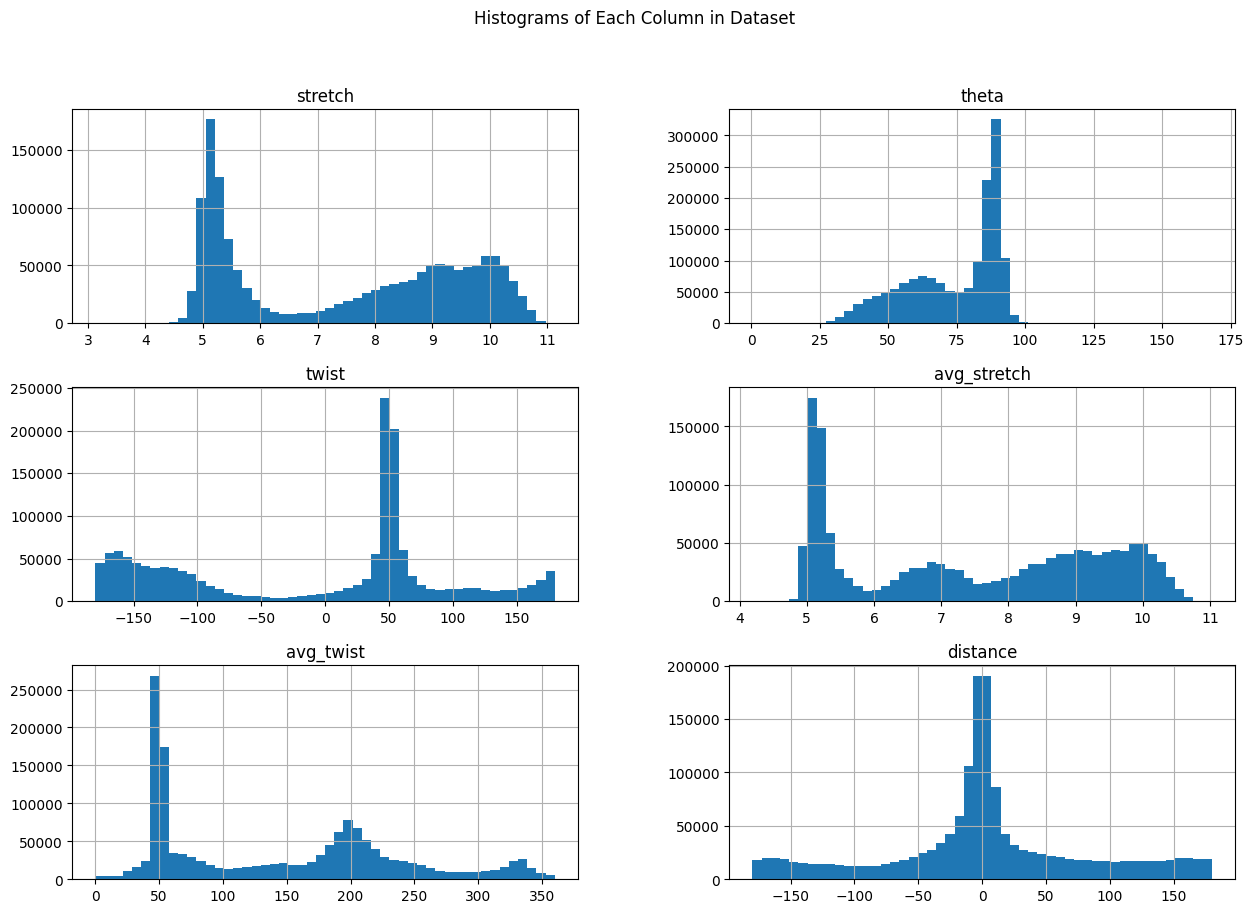

In [9]:
df.hist(figsize=(15,10), bins=50)
plt.suptitle("Histograms of Each Column in Dataset")
plt.show()

Initial checking for outliers via boxplots

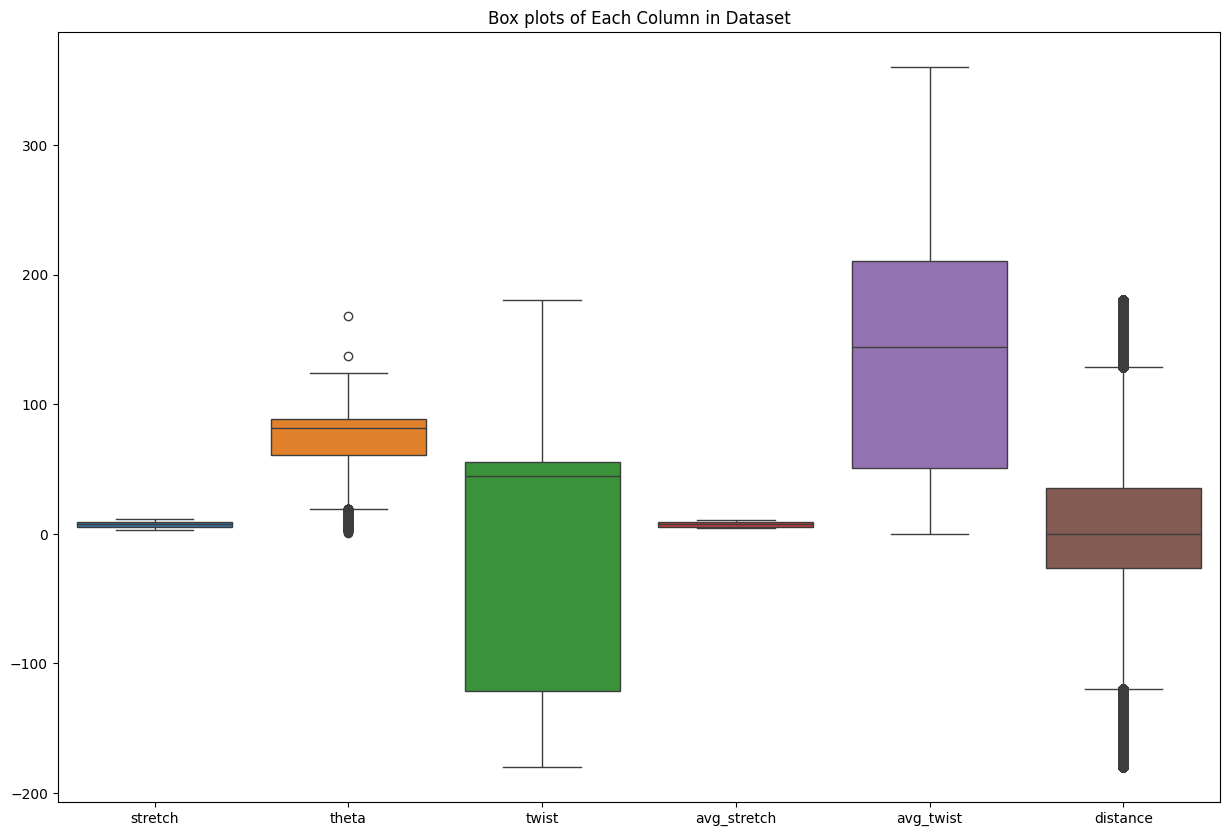

In [10]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.title("Box plots of Each Column in Dataset")
plt.show()

<li>Only "theta" seems to have potential outliers, which might be worth investigating further.

<li>Only "twist" shows a notable skewness in its distribution.

<li>"theta" and "twist" have a more significant spread, showing variability in the measurements.

<li> "avg_stretch" and "avg_twist" are the most consistent datasets with very tight distributions. This could indicate that average measurements across data points do not vary much.

## 3.3/ Identify and remove outliers

My strategy: Using the IQR method first to remove outliers and then normalizing the data before applying DBSCAN. (because if you want to use DBSCAN to remove outliers, the data should be scaled since DBSCAN is sensitive to the scale of the data. On the other hand, normalization is influenced by outliers.)

In [4]:
df_id = df["id"]
df_without_id = df.drop(columns=["id"])

In [5]:
# 1. Remove outliers using IQR
Q1 = df_without_id.quantile(0.25)
Q3 = df_without_id.quantile(0.75)
IQR = Q3 - Q1
df_without_id = df_without_id[~((df_without_id < (Q1 - 1.5 * IQR)) | (df_without_id > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
df_without_id.shape

(1250320, 6)

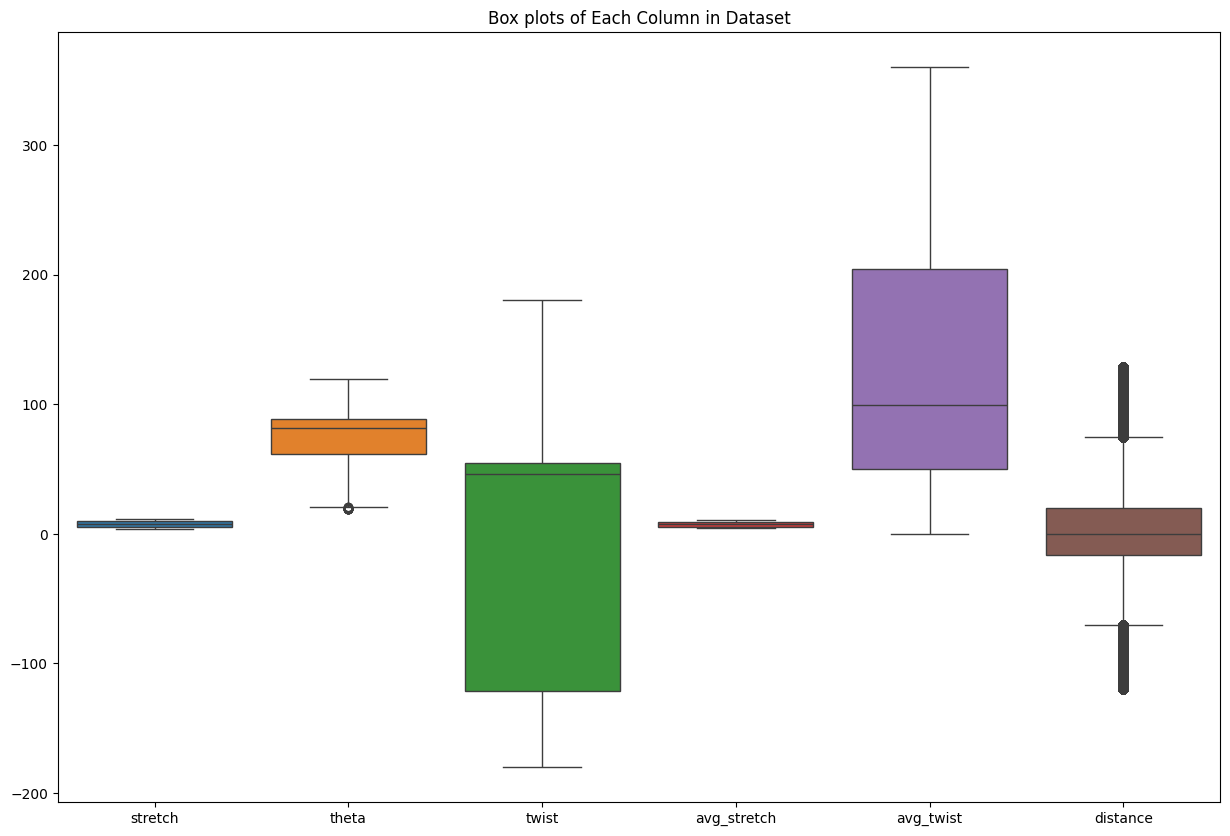

In [15]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_without_id)
plt.title("Box plots of Each Column in Dataset")
plt.show()

In [7]:
# 2. Normalize the data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_without_id), columns=df_without_id.columns)

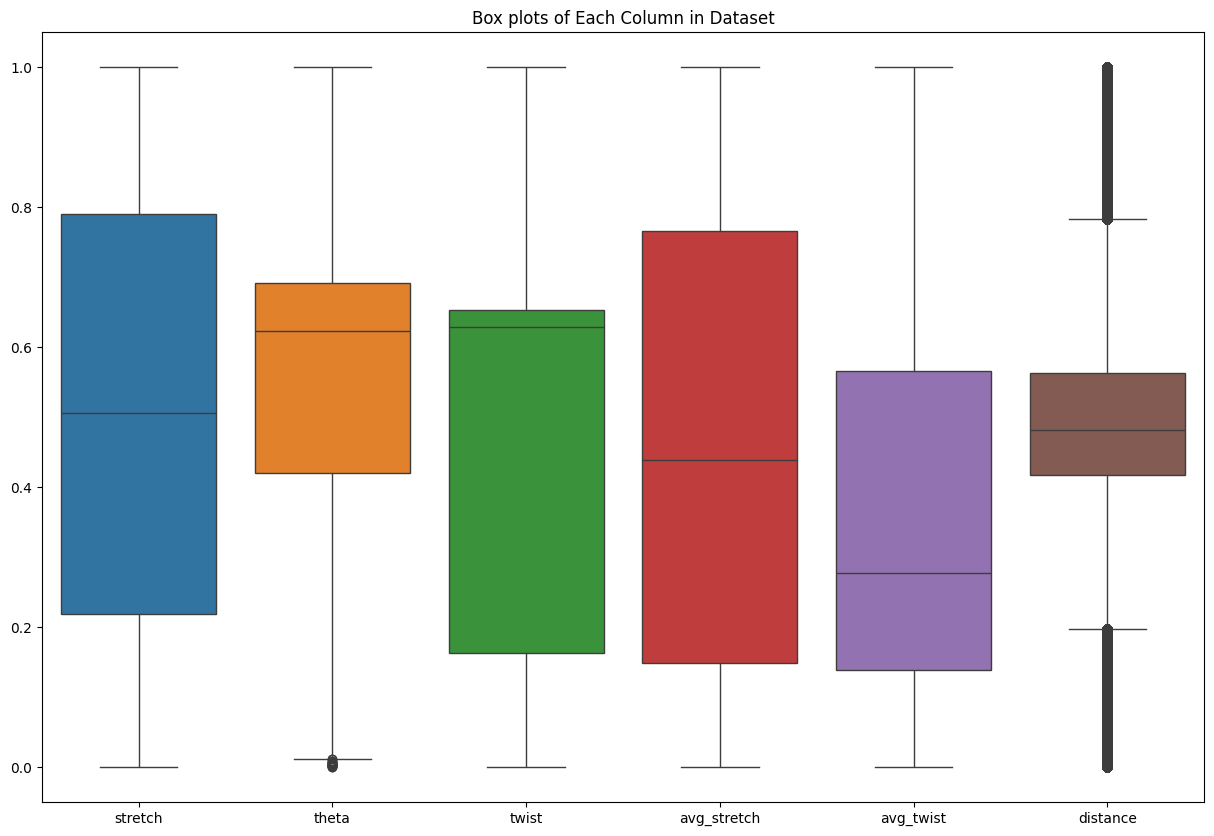

In [17]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_normalized)
plt.title("Box plots of Each Column in Dataset")
plt.show()

In [8]:
# 3. # Create an HDBSCAN clustering model
clusterer = HDBSCAN(min_samples=7, n_jobs=-1)
# Apply clustering
clusters = clusterer.fit_predict(df_normalized)
# Add cluster labels to the dataframe
df_normalized['Cluster'] = clusters

### Initial checking for relationships between all pairs of columns via visualization

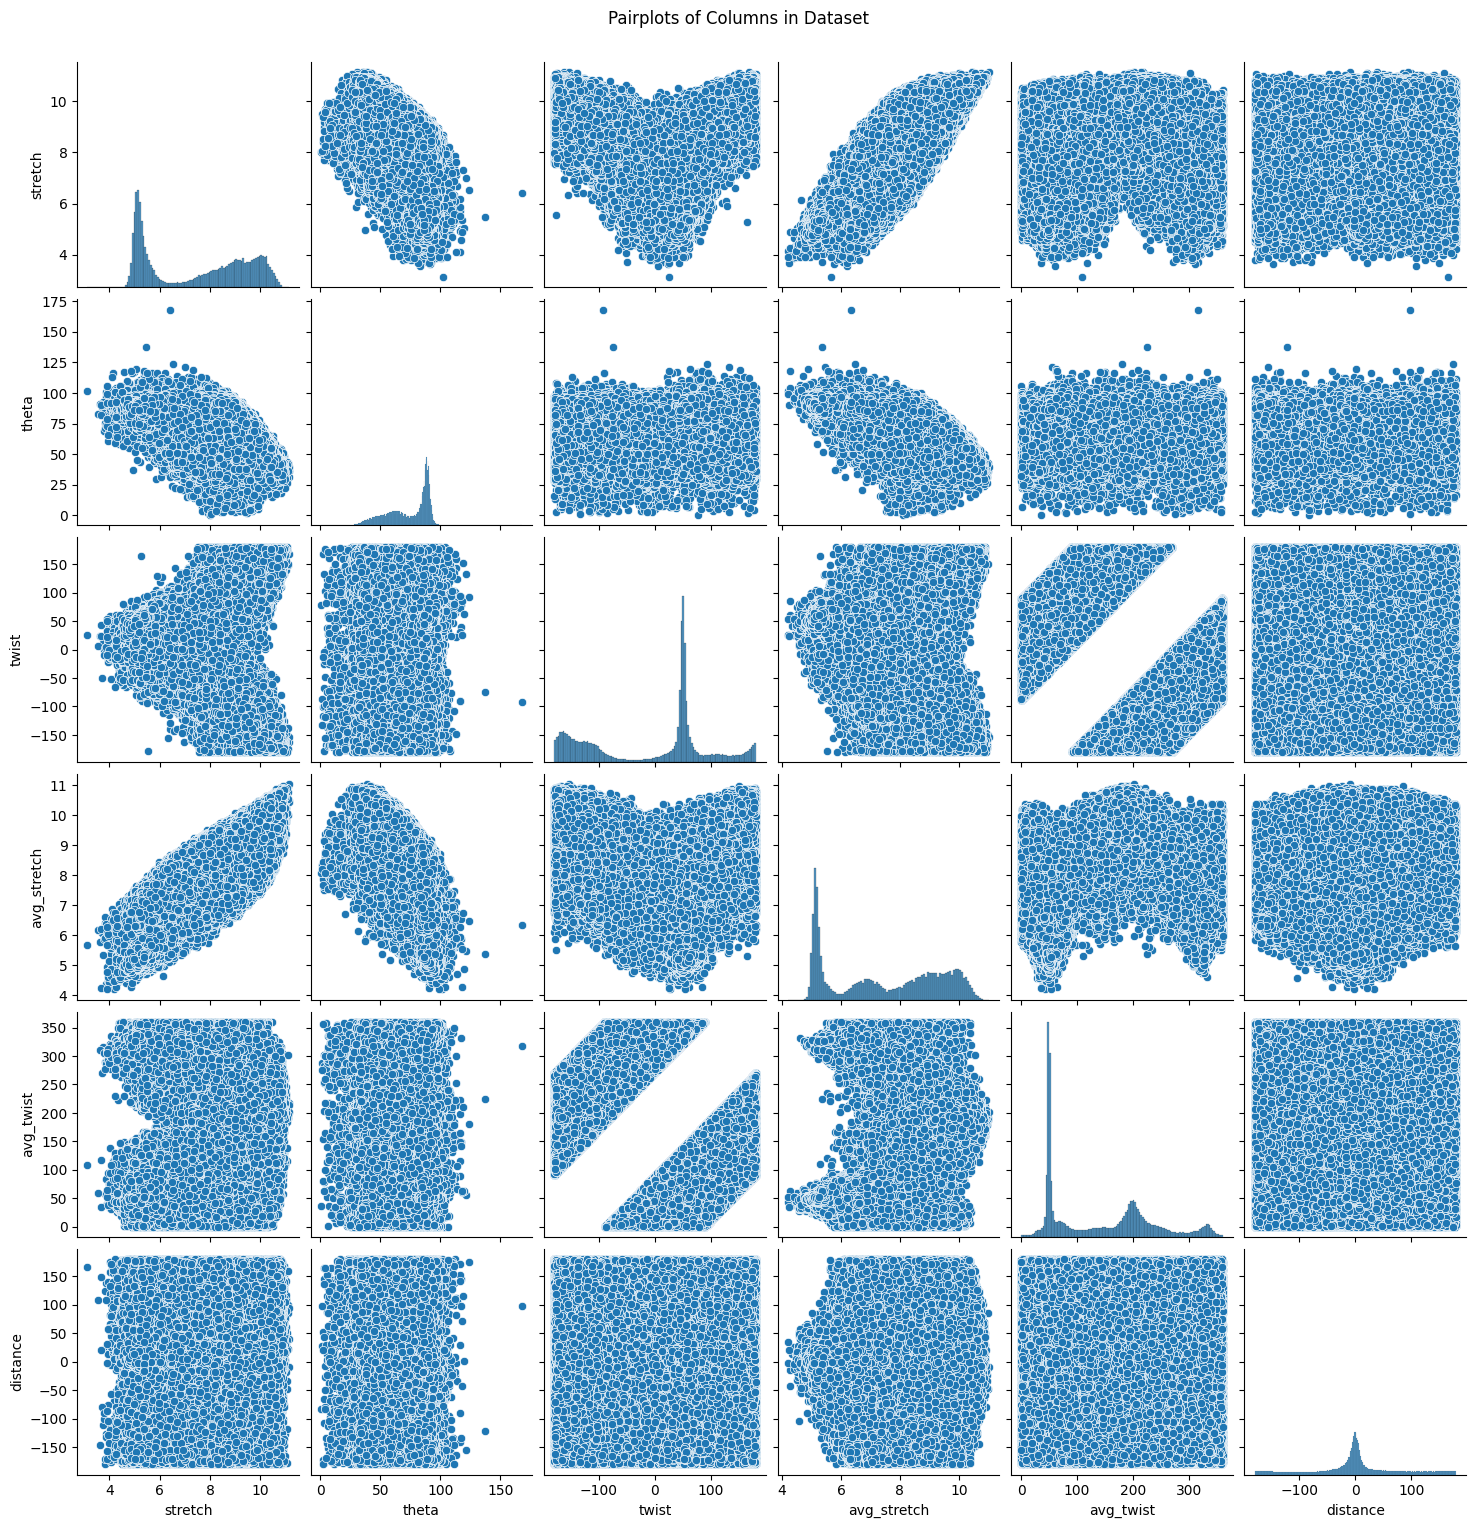

In [11]:
sns.pairplot(df)
plt.suptitle("Pairplots of Columns in Dataset", y=1.02)
plt.show()


<li>stretch vs. theta: There's a distinct curved (perhaps parabolic) relationship, suggesting that as "stretch" increases or decreases from a central point, "theta" also changes in a predictable manner.


<li>stretch vs. twist: There appears to be a somewhat V-shaped scatter, implying a potential relationship where extreme values of "stretch" correspond to low "twist" values.


<li>theta vs. twist: The data points seem to be concentrated around a vertical line, suggesting that specific "theta" values correspond to a wide range of "twist" values.


<li>The plots of "distance" vs. other variables are quite dispersed, with no apparent strong relationship or pattern.


<li>"stretch vs. theta" and "stretch vs. twist" both seem to have symmetrical patterns, indicating that the relationship might be quadratic or similar in nature.

In [12]:
df_id = df["id"]
df_without_id = df.drop(columns=["id"])

In [13]:
import pandas as pd

# For each column, compute the IQR and use it to detect outliers
for col in df_without_id.columns:
    Q1 = df_without_id[col].quantile(0.25)
    Q3 = df_without_id[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    df_without_id = df_without_id[(df_without_id[col] >= lower_bound) & (df_without_id[col] <= upper_bound)]

# The resulting df has outliers removed


In [15]:
df_without_id.shape

(1250320, 6)

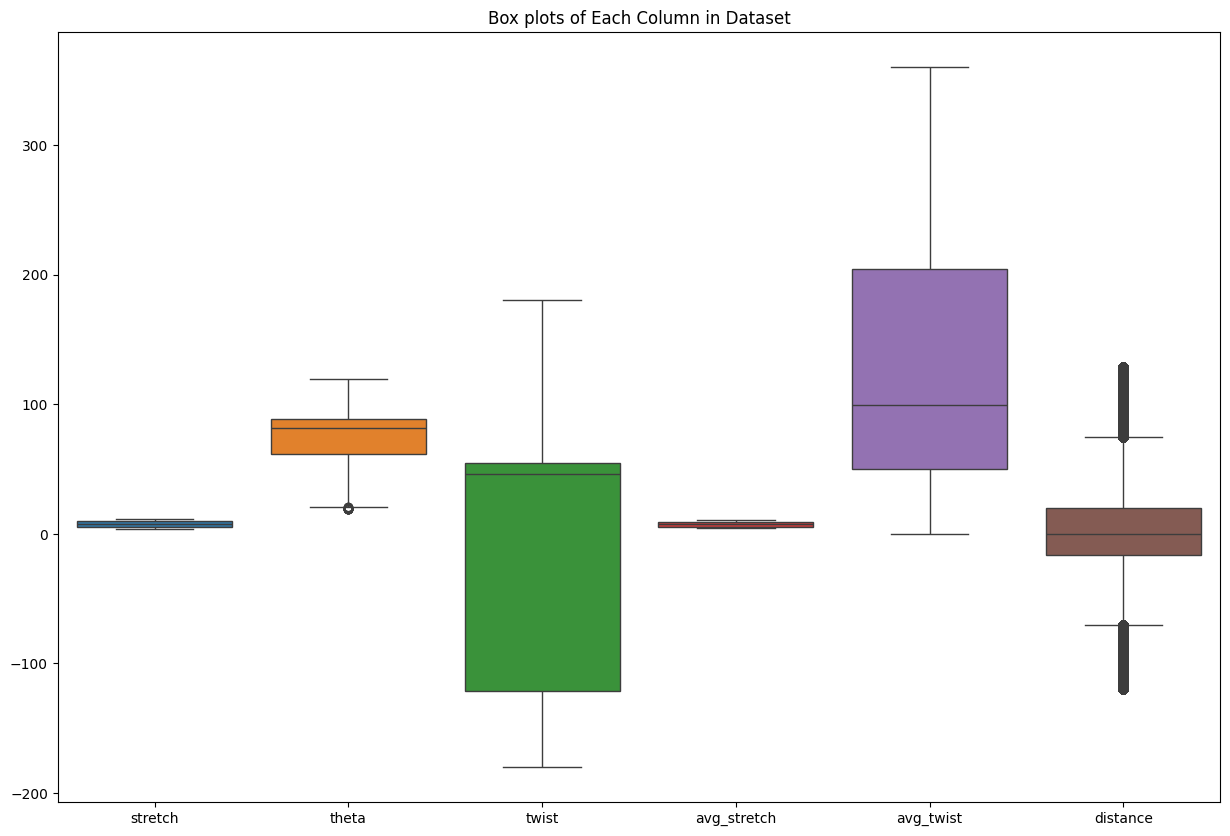

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_without_id)
plt.title("Box plots of Each Column in Dataset")
plt.show()

## Further Correlation Analysis

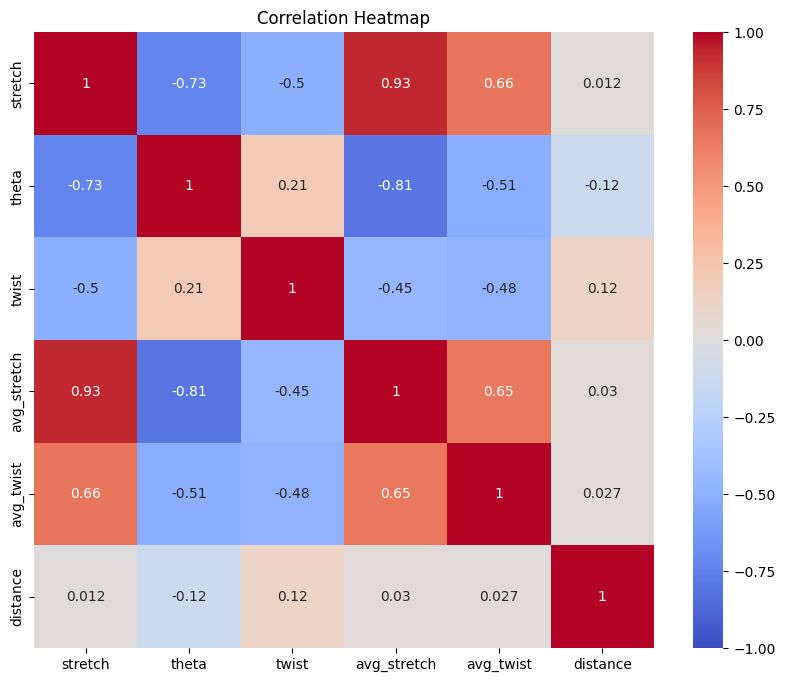

In [18]:
correlation_matrix = df_without_id.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

the heatmap described in the provided code measures linear correlation. Specifically, it calculates the Pearson correlation coefficient, which measures the linear relationship between two datasets.


#### High Positive Correlation:

<li>stretch and avg_stretch have a very strong positive correlation of 0.93. This suggests that as the value of stretch increases, avg_stretch also tends to increase, and vice versa.

<li>stretch and avg_twist show a notable positive correlation of 0.66, indicating a moderate linear relationship between these variables.

<li>avg_stretch and avg_twist are also positively correlated with a coefficient of 0.65, indicating that they tend to increase together.<br>

#### High Negative Correlation:

<li>stretch and theta have a strong negative correlation of -0.73, which implies that as stretch values increase, theta values typically decrease, and vice versa.

<li>theta and avg_stretch show a strong negative correlation of -0.81. This suggests that as theta increases, avg_stretch usually decreases and vice versa.<br>

#### Moderate Correlations:

<li>twist has a moderate negative correlation with both avg_stretch (-0.45) and avg_twist (-0.48), suggesting that increases in twist values might correspond with decreases in the average values of stretch and twist.

<li>theta and twist have a weak positive correlation of 0.21, indicating a slight tendency for these variables to increase together, but the relationship isn't very strong.

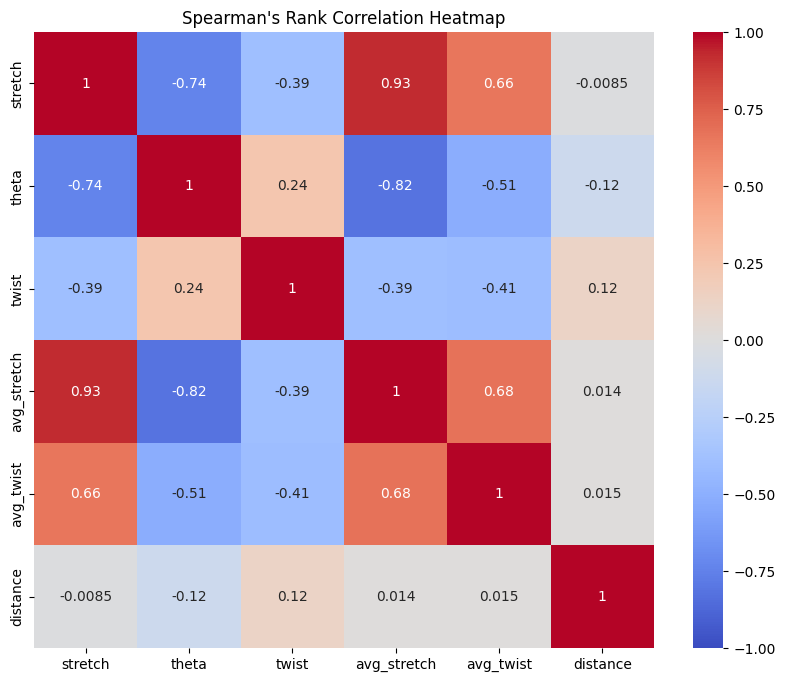

In [20]:
# Compute Spearman's rank correlation for the dataset
spearman_corr = df_without_id.corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank Correlation Heatmap")
plt.show()

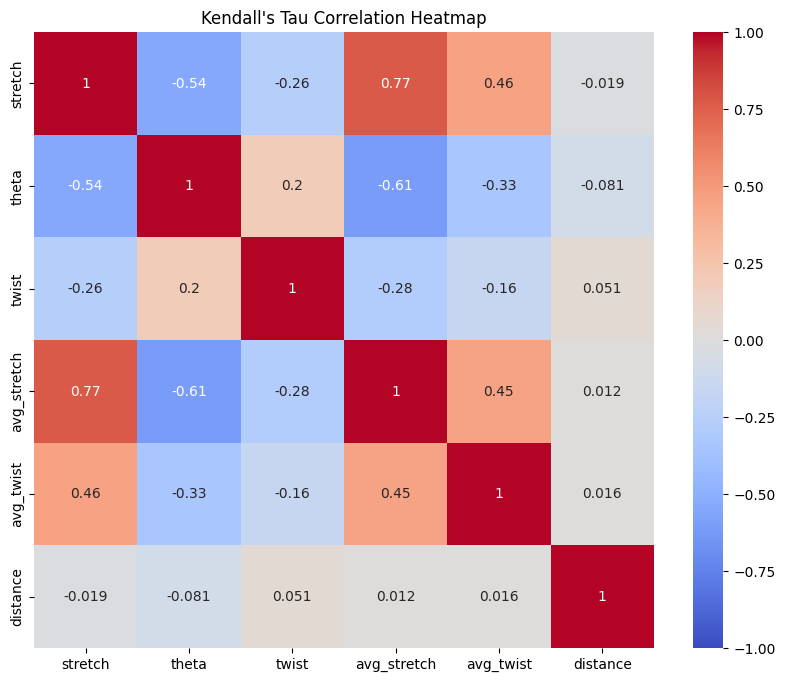

In [21]:
# Compute Kendall's Tau correlation for the dataset
kendall_corr = df_without_id.corr(method='kendall')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Tau Correlation Heatmap")
plt.show()

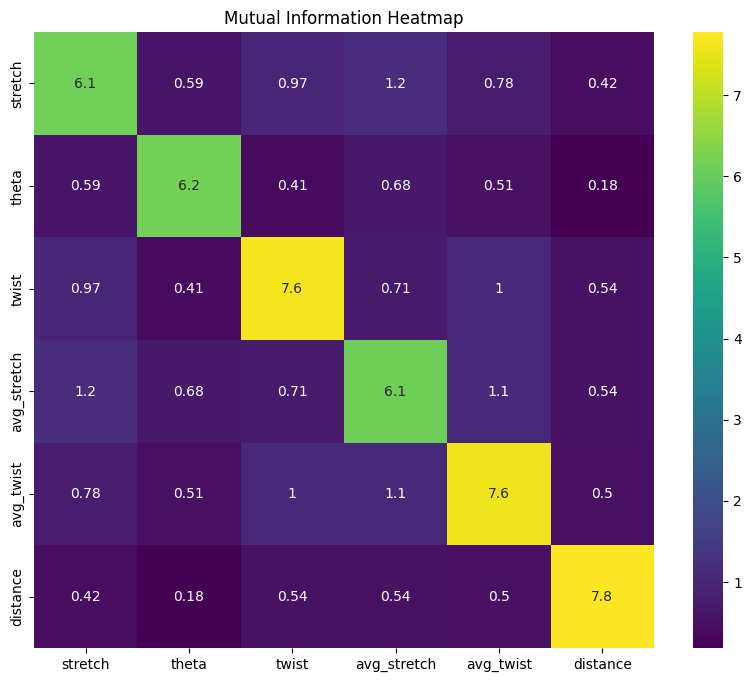

In [25]:
def compute_MI(x, y, discrete_features='auto'):
    return mutual_info_regression(x.values.reshape(-1, 1), y, discrete_features=discrete_features)[0]

# Compute Mutual Information matrix
mi_matrix = pd.DataFrame(index=df_without_id.columns, columns=df_without_id.columns)
for col1 in df_without_id.columns:
    for col2 in df_without_id.columns:
        mi_matrix.loc[col1, col2] = compute_MI(df_without_id[col1], df_without_id[col2])

# Convert the MI matrix to float type
mi_matrix = mi_matrix.astype(float)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, cmap='viridis')
plt.title("Mutual Information Heatmap")
plt.show()

In [26]:
mi_matrix

,stretch,theta,twist,avg_stretch,avg_twist,distance
stretch,6.135604,0.588844,0.967568,1.155325,0.780959,0.424265
theta,0.589055,6.173453,0.413241,0.679064,0.505281,0.183280
twist,0.967765,0.412915,7.634948,0.714690,1.047376,0.537414
avg_stretch,1.154401,0.679610,0.714312,6.110803,1.055150,0.536266
avg_twist,0.781772,0.505278,1.047299,1.055601,7.594165,0.495934
distance,0.423950,0.182285,0.536409,0.535333,0.495863,7.777677
